In [1]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scanpy.tools._utils import get_init_pos_from_paga 
from sklearn.metrics import mean_squared_error

import anndata as an
import scanpy as sc
import scvi
import scvelo as scv

/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 244 ms, sys: 3.31 s, total: 3.55 s
Wall time: 7.4 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

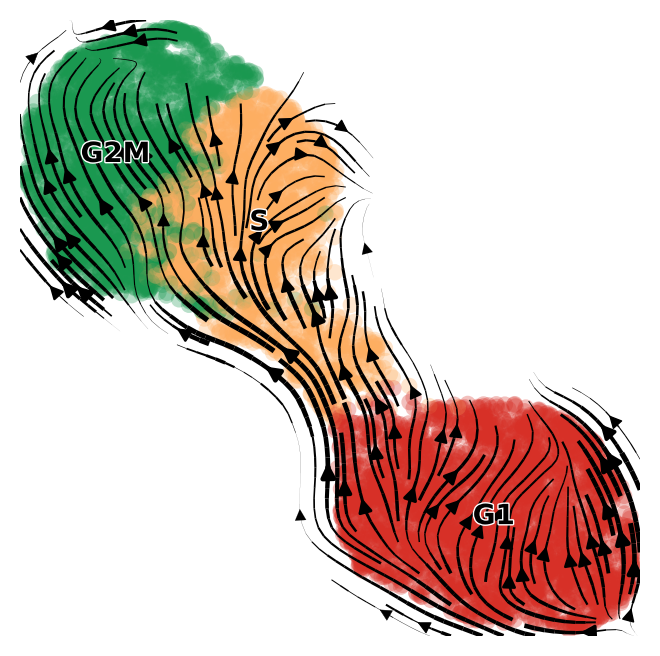

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

V = -np.array(adata.obsm["velocity_umap"])           

scv.pl.velocity_embedding_stream(
    adata,
    color='cluster_phase',
    V=V,
    smooth=0.8,
    title="",
)

# genes

In [4]:
cell_cycle_genes = [x.strip() for x in open('../resources/regev_lab_cell_cycle_genes.txt')]

s_genes = [x for x in cell_cycle_genes[:43] if x in adata.var_names]
g2m_genes = [x for x in cell_cycle_genes[43:] if x in adata.var_names]

print(f"Total cell cycle genes in file: {len(cell_cycle_genes)}")
print(f"S-phase genes available in adata: {len(s_genes)} / 43")
print(f"G2M-phase genes available in adata: {len(g2m_genes)} / {len(cell_cycle_genes) - 43}")
print("\nFirst few S-phase genes found:", s_genes[:10])
print("First few G2M-phase genes found:", g2m_genes[:10])

Total cell cycle genes in file: 97
S-phase genes available in adata: 42 / 43
G2M-phase genes available in adata: 52 / 54

First few S-phase genes found: ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6']
First few G2M-phase genes found: ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2']


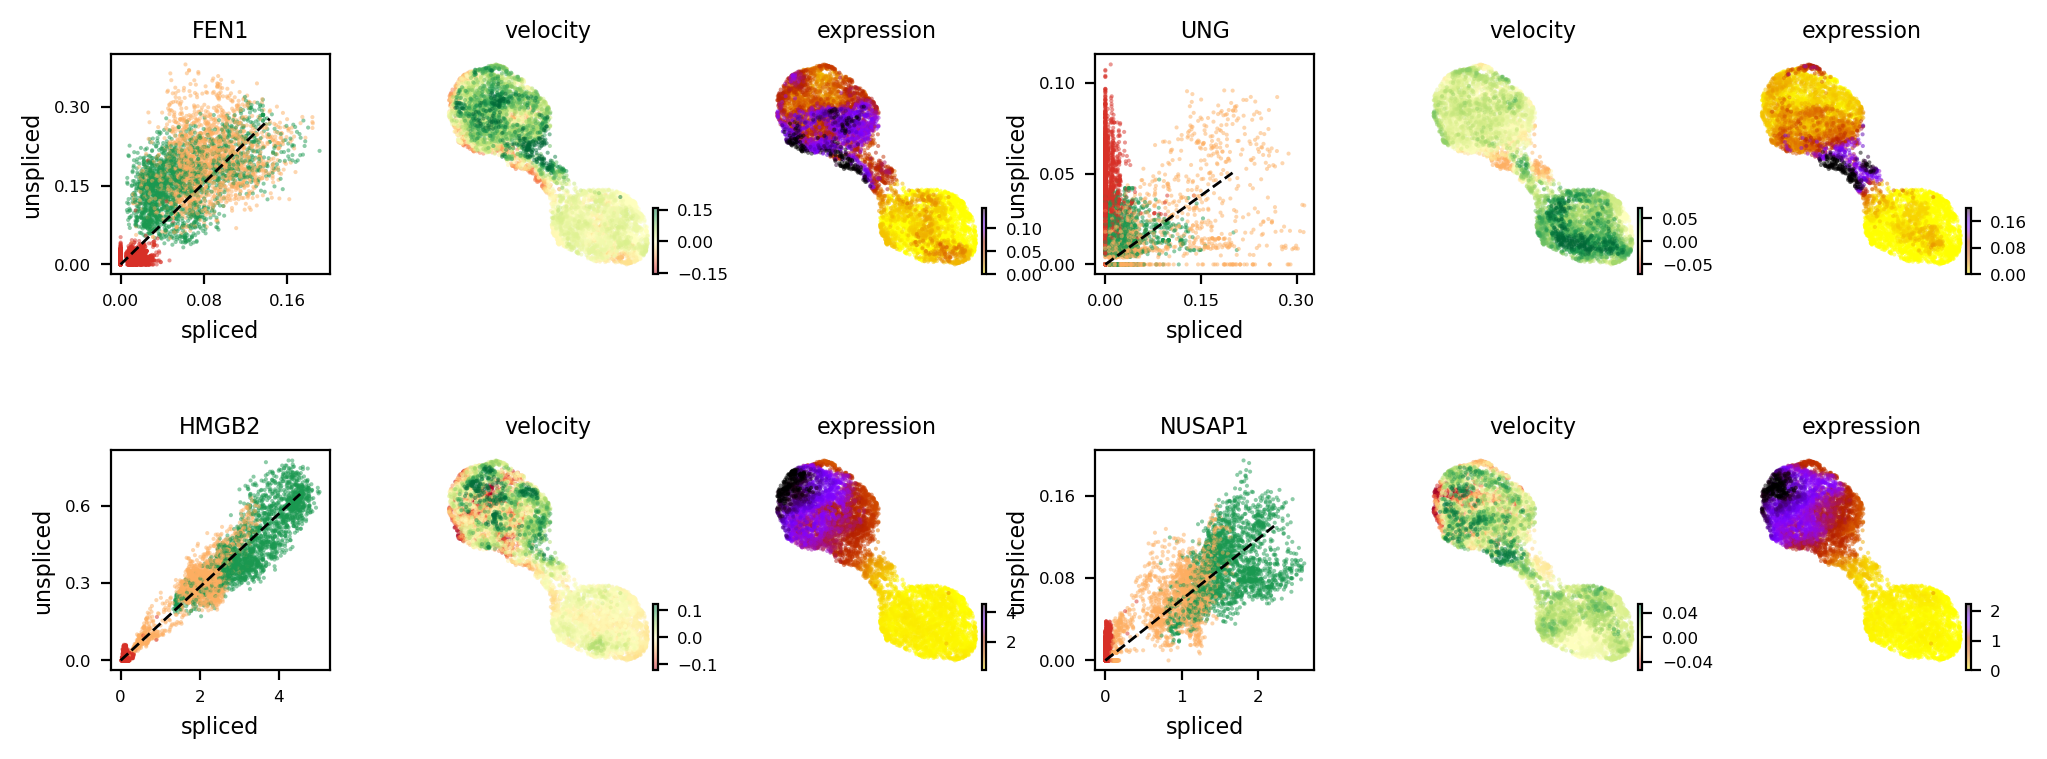

In [14]:
genes = [
    'FEN1', 'UNG', # S
    'HMGB2', 'NUSAP1', # G2M
]

scv.pl.velocity(
    adata,
    var_names=genes,
    color='cluster_phase', ncols=2,
)

# Velocity Genes

In [17]:
%%time
scv.tl.rank_velocity_genes(
    adata,
    groupby='cluster_phase'
)

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
CPU times: user 441 ms, sys: 460 ms, total: 901 ms
Wall time: 902 ms


G1      G2M       S
0  AURKA    TIMP3    SMC4
1  H2AC6     HIP1  CCDC80
2  TMTC1    BICC1   ALPK2
3  CDCA8  ST3GAL3   ACTG1
4  TACC3   COL6A3    KNL1

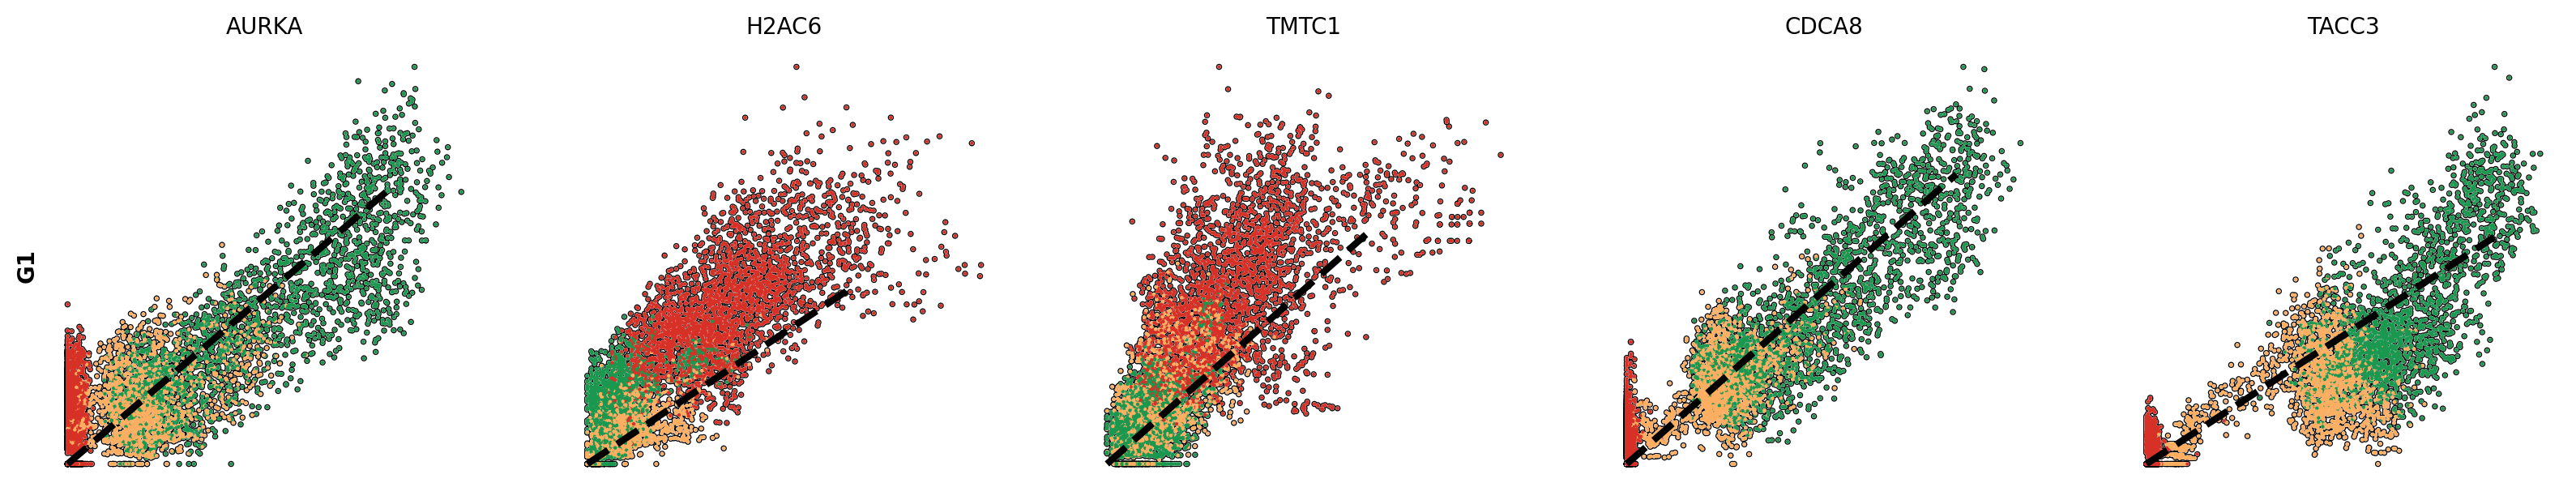

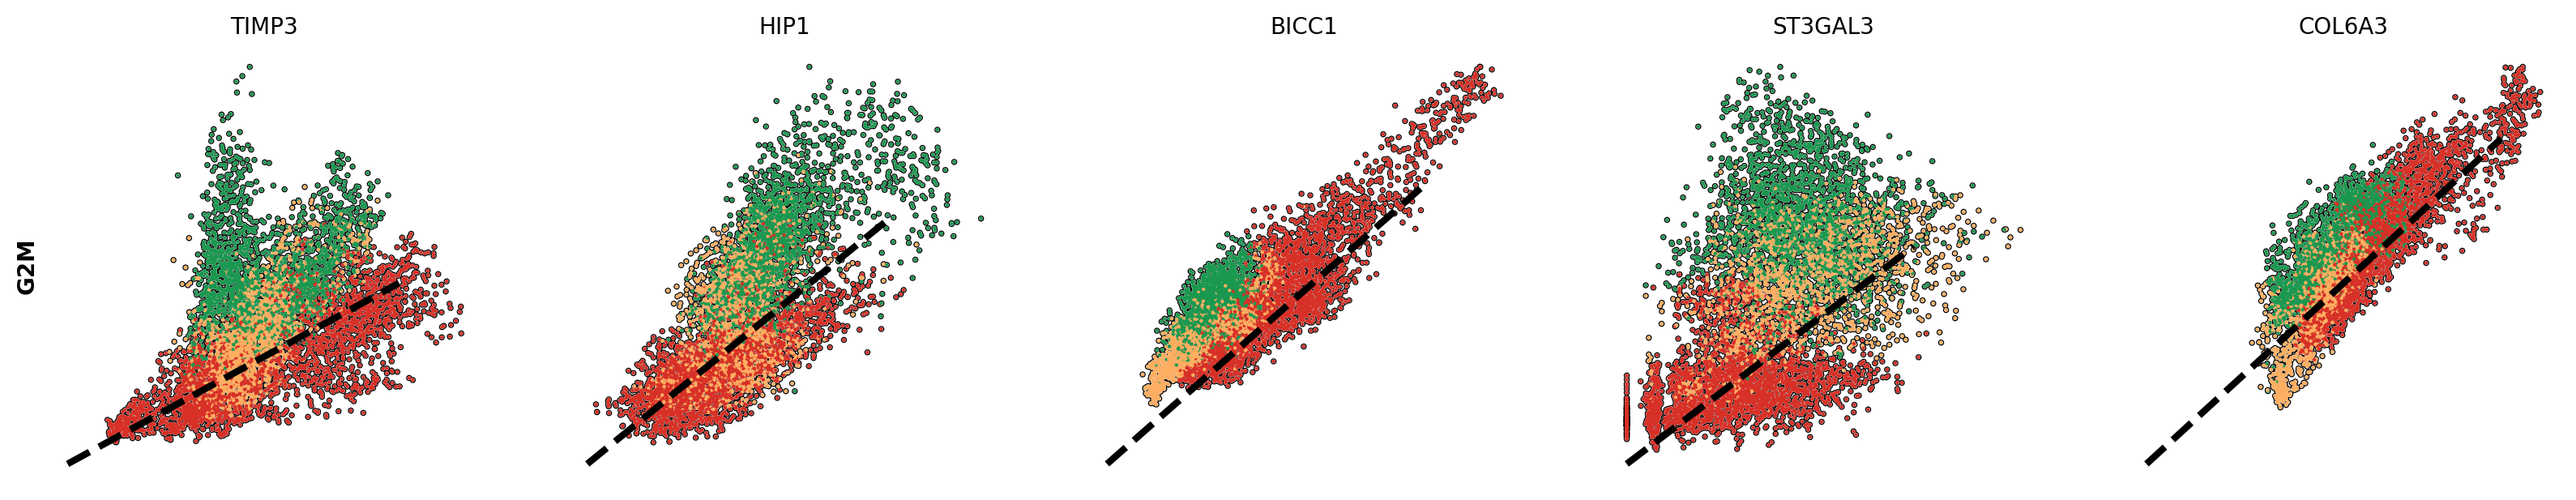

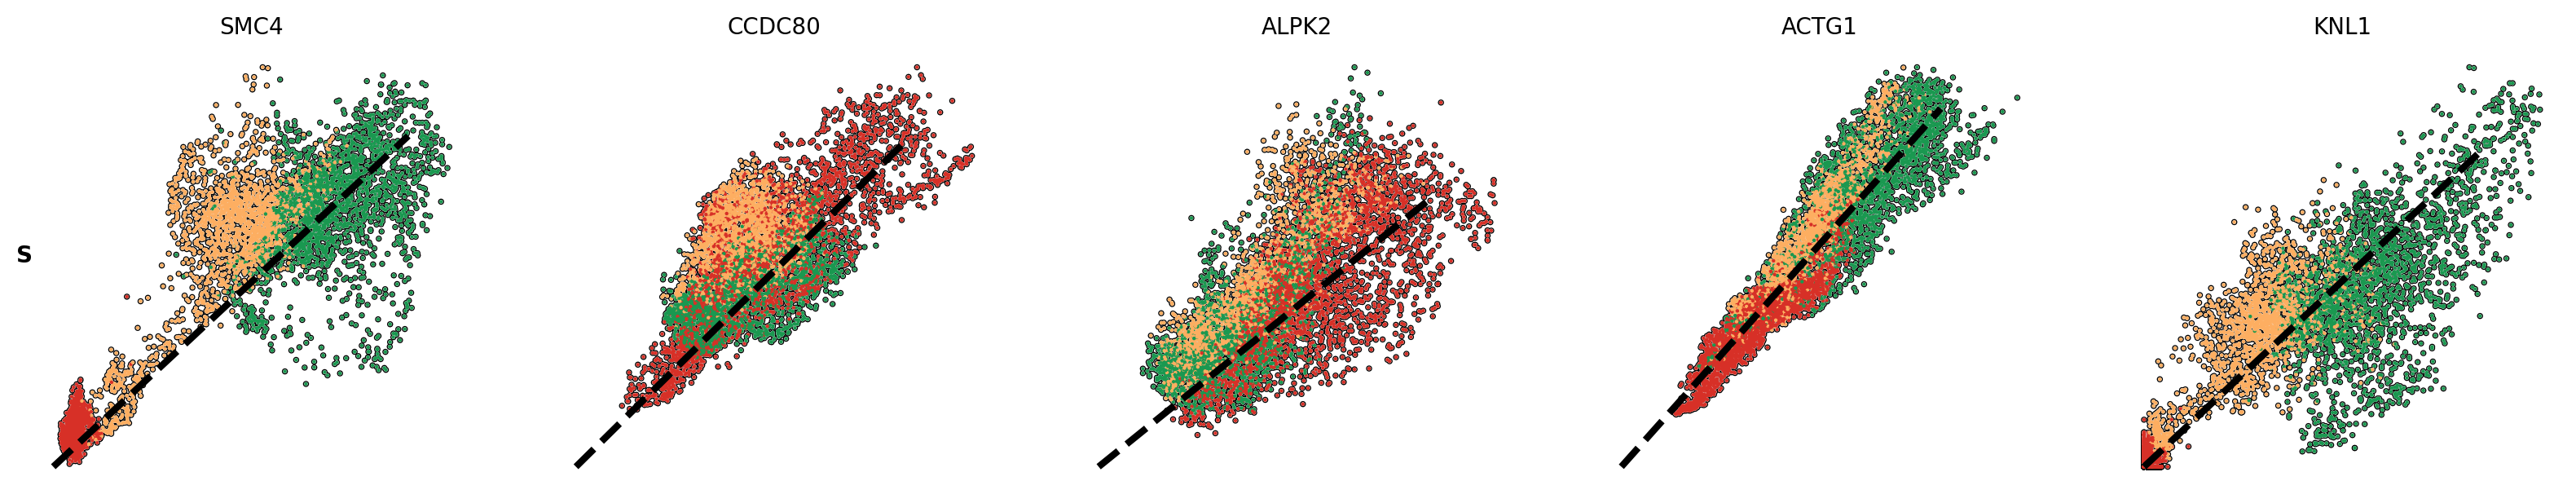

In [35]:
n_genes = 5

for column in df.columns:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 3.5
    
    scv.pl.scatter(
        adata, 
        df[column][:n_genes], 
        ylabel=column,
        color='cluster_phase',
        add_outline=True,
        frameon=False,
        size=10,
        linewidth=3,
        dpi=200,
    )

In [46]:
var = adata.var.copy()
var = var[var['velocity_genes']]
print(f"{var.shape=}")
# [print(x) for x in var.index.to_list()]

var.head()

var.shape=(394, 24)


mt   ribo     hb  n_cells_by_counts  mean_counts  log1p_mean_counts  \
ABCA1  False  False  False               5649     0.508740           0.411275   
ACKR4  False  False  False               2793     0.216390           0.195888   
ACTA2  False  False  False               4236     0.633801           0.490909   
ACTC1  False  False  False                408     0.047039           0.045966   
ACTG1  False  False  False              15951    11.115388           2.494476   

       pct_dropout_by_counts  total_counts  log1p_total_counts  n_counts  ...  \
ABCA1              72.262595       10361.0            9.245901    1799.0  ...   
ACKR4              86.285967        4407.0            8.391176    2787.0  ...   
ACTA2              79.200628       12908.0            9.465680    8480.0  ...   
ACTC1              97.996661         958.0            6.865891     768.0  ...   
ACTG1              21.678287      226376.0           12.329957  130722.0  ...   

       highly_variable_nbatches  highly_variable_intersection  \
ABCA1                         2                          True   
ACKR4                         2                          True   
ACTA2                         2                          True   
ACTC1                         2                          True   
ACTG1                         1                         False   

            feature_id  gene_count_corr  velocity_gamma  velocity_qreg_ratio  \
ABCA1  ENSG00000165029          -0.1157        0.051941             0.073616   
ACKR4  ENSG00000129048          -0.1340        0.887286             1.110091   
ACTA2  ENSG00000107796           0.0127        0.558382             0.612370   
ACTC1  ENSG00000159251           0.0364        0.583185             0.500239   
ACTG1  ENSG00000184009           0.3168        2.719780             2.742739   

      velocity_r2  velocity_genes  spearmans_score  velocity_score  
ABCA1    0.110255            True         0.399135               0  
ACKR4    0.472181            True         0.774874              13  
ACTA2    0.108545            True         0.545485               6  
ACTC1    0.250518            True         0.395125               0  
ACTG1    0.856920            True         0.940949              31  

[5 rows x 24 columns]